# Notebook说明
本Notebook是对论文*A Suggested Computation for Maximal Multi-Commodity Network Flows*的Python实现。

尝试在较大规模的问题上试验一下这个算法，并看看其对比直接解线性规划的优劣势。

In [195]:
import numpy as np
import networkx as nx

# 指定nbagg后端以启用交互功能
%matplotlib notebook
import matplotlib.pyplot as plt

# 引入一些工具函数用于生成随机连通图
from itertools import combinations, groupby
import random
import time

## 生成随机的多物品最大流问题
主要包含两个问题：
1. 随机生成固定数量的点和边的带权图，该图要求连通，否则可以直接分解为更小规模的问题。
2. 随机生成不同物品，其发点和收点随机

In [196]:
# 随机生成一些含有固定点和边数量的连通图，其权重为最小范围和最大范围的任意数
def generate_graph(node_num, edge_num, min_capacity, max_capacity):
    G = nx.Graph()
    G.add_nodes_from(range(1, node_num+1))
    ei = 1
    
    # 先生成连通图所需的边
    edges = combinations(range(1, node_num+1), 2)
    for _, node_edges in groupby(edges, key=lambda x:x[0]):
        node_edges = list(node_edges)
        random_edge = list(node_edges)
        
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge, weight=random.randint(min_capacity, max_capacity), ei=ei)
        edge_num = edge_num - 1
        ei = ei + 1

        
    # 然后逐步添加随机边直到所有的边用完
    while edge_num > 0:
        p1 = random.randint(1, node_num)
        p2 = random.randint(1, node_num)
        # 两点一样就再随机一次
        if p1 == p2:
            continue
        # 看看图中有没有这样的边了，如果有，那也再随机一次
        if G[p1].get(p2, None) is not None:
            continue
        # 上面都满足的话就在图中添加该边，并让剩余边数-1
        G.add_edge(p1, p2, weight=random.randint(min_capacity, max_capacity), ei=ei)
        edge_num = edge_num-1
        ei = ei + 1
    
    return G

In [197]:
node_num = 20
edge_num = 40
commodity_num = 10

graph_nodes = range(1, node_num+1)
G = generate_graph(node_num, edge_num, 3, 25)

<IPython.core.display.Javascript object>


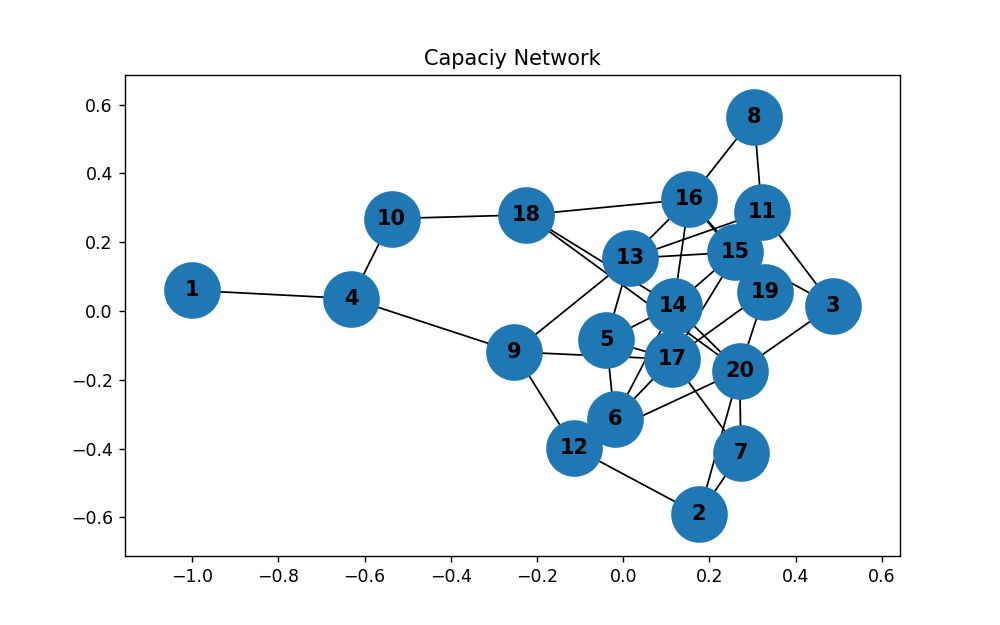

In [198]:
# 绘制图
fig, ax = plt.subplots(figsize=(8, 5))
plt.title('Capaciy Network')

edge_labels=nx.get_edge_attributes(G, 'weight')

nx_pos = nx.spring_layout(G) # 弹簧布局
nx.draw(G, nx_pos, with_labels=True, font_weight='bold', ax=ax, node_size=1000)
# 画标签显得比较乱
# nx.draw_networkx_edge_labels(G,nx_pos,edge_labels=edge_labels, ax=ax)

ax.set_axis_on()
ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.show()

In [199]:
# 随机生成固定种数的商品，并根据节点个数随机选择source和sink，每个最多允许有max_set_capacity个源点/汇点
def generate_commodity(N, node_num, max_set_capacity=2):
    Source = []
    Sink = []
    
    for i in range(N):
        # 先确定源点和汇点个数
        Ni_source = random.randint(1, max_set_capacity)
        Ni_sink = random.randint(1, max_set_capacity)
        
        # 在1-node_num范围中采样Ni_source+Ni_sink个点，并直接分配出去
        point_list = random.sample(range(1, node_num+1), Ni_sink+Ni_source)
        Source.append(point_list[: Ni_source])
        Sink.append(point_list[Ni_source: Ni_sink+Ni_source])
    
    return Source, Sink

In [200]:
Source, Sink = generate_commodity(commodity_num, node_num)
Source[0:3], Sink[0:3]

([[12], [17], [11, 7]], [[13, 1], [11, 1], [16, 19]])

In [201]:
# 使用Networkx自带的BFS查找算法查找从source到sink的简单路径
# 查找后生产相应的A矩阵
A_list = []

# 记录边的数目
edge_numbers = G.number_of_edges()
# 记录路径的映射
idx = 0
path2Ci = {}
Ci2path = {}
# 记录路径对应的物品
Ci2Commodity = {}


for j in range(len(Source)):
    # 取出商品j的源点和汇点
    sources = Source[j]
    sinks = Sink[j]
    
    # 源点和汇点两两组合，生成简单路径
    for source in sources:
        for sink in sinks:
            # 寻找两点间的简单路径
            simple_paths = nx.all_simple_edge_paths(G, source, sink)
            for path in simple_paths:
                # 对每条路径创建一列
                Ai = np.zeros(edge_numbers)
                nodes = []
                # 将该列每个该路径上的边置为1
                for edge in path:
                    edge_attr = G[edge[0]][edge[1]]
                    # 取出边对应的序号
                    ei = edge_attr['ei']
                    # 对应的位置赋值1
                    Ai[ei-1] = 1
                    # 记录端点
                    nodes.append(edge[0])
                # 记录映射
                nodes.append(edge[1])
                # path2Ci时，由于不同商品可能存在相同的路径，所以这边的值应该是个列表
                if path2Ci.get(', '.join(str(node) for node in nodes), None) is None:
                    path2Ci[', '.join(str(node) for node in nodes)] = [idx]
                else:
                    path2Ci[', '.join(str(node) for node in nodes)].append(idx)
                # path2Ci[', '.join(str(node) for node in nodes)] = idx
                Ci2path[idx] = ', '.join(str(node) for node in nodes)
                Ci2Commodity[idx] = j
                idx += 1
                # 路径处理完后将该列加入A中
                A_list.append(Ai)
# 将所有列拼接，并转置成论文上的A矩阵形状
A = np.vstack(A_list).T
# 记录路径的数量，记为NC
NC = len(Ci2path)
A

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [202]:
A.shape

(40, 268838)

In [203]:
NC

268838

In [204]:
# 创建b向量和C向量
b = np.zeros(edge_numbers)
for n1, n2, data in G.edges(data=True):
    b[data['ei']-1] = data['weight']

C = np.hstack((np.ones(NC), np.zeros(edge_numbers)))

## 导出A矩阵、b向量和C向量
导出A矩阵、b向量和C向量，在其他求解器中求解该线性规划问题，印证答案可靠性。

In [217]:
# 将A矩阵、b向量和C向量导出为csv文件
np.savetxt('A_matrix.csv', A, delimiter=',')
np.savetxt('b_vector.csv', b, delimiter=',')
np.savetxt('c_vector.csv', np.ones(NC), delimiter=',')
print("导出成功!")

导出成功!


In [218]:
b, C

(array([12.,  5., 24., 20., 19.,  7., 21., 21., 20., 19., 14.,  8., 20.,
        22., 11.,  8., 16.,  4.,  9., 11., 15.,  4., 18., 16., 18., 18.,
        20., 24., 14., 11., 20., 11., 14., 24., 23.,  8.,  7., 15., 18.,
         9.]),
 array([1., 1., 1., ..., 0., 0., 0.]))

In [223]:
# 建立数学模型
# 首先，引入松弛变量，拓展A矩阵
A_extend = np.hstack((A, np.eye(edge_numbers)))

# 准备初始基矩阵，为了解决问题的一般性，选择xn+1~xn+r
B_idx = np.arange(NC,NC+edge_numbers)
# 初始B矩阵
B = A_extend[:, B_idx]

# 单纯形乘子
CB = C[B_idx]
B_inv = np.linalg.inv(B)
simplex_multipliers = np.dot(CB, B_inv) # alpha_r = CB * B-1

print("初始基矩阵B：")
print(B)
print("单纯形乘子值：")
print(simplex_multipliers)

初始基矩阵B：
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
单纯形乘子值：
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [224]:
# 输入单纯形算子、源点、汇点，返回第一个找到的路径
def get_entry_basis_vector(simplex_multipliers):
    # 新建一个图
    LG = nx.Graph()
    # 加入节点
    LG.add_nodes_from(graph_nodes)
    # 加入边和权重，注意权重为这边的单纯形算子
    for n1, n2, data in G.edges(data=True):
        LG.add_edge(n1, n2, weight=simplex_multipliers[data['ei']-1], ei=data['ei'])
        

    # 已知边里面已经没有负权了，所以用Dijkstra算法找最短路是个更好的选择
    # 为了避免重复计算相同的最短路径，可以记录下最短路的长度和对应的路径
    shortest_path_length = {}
    shortest_path = {}
    
    # 开始遍历每个商品的源点和汇点
    for j in range(len(Source)):
        sources = Source[j]
        sinks = Sink[j]
        
        for source in sources:
            for sink in sinks:
                if shortest_path.get(f"{source}->{sink}", None) is None:
                    shortest_path[f"{source}->{sink}"] = nx.dijkstra_path(LG, source, sink)
                    shortest_path_length[f"{source}->{sink}"] = nx.dijkstra_path_length(LG, source, sink)
                
                # 如果物品的价值不同，这边也可以改为小于对应的j物品的价值
                if shortest_path_length[f"{source}->{sink}"] < 1: # 0.999999999999999:
                    return shortest_path[f"{source}->{sink}"]
    # 如果没有找到，说明已经迭代到最优了，返回None值
    return None

In [225]:
# 开始迭代单纯形
max_iter = 1000
start = time.time()  # 开始计时
e = 1e-14           # 对抗舍入误差，对单纯形算子和算出来的b都补偿一个非常小的正数
for iter_ in range(max_iter):
    print(f"--------第{iter_+1}轮迭代开始------------")
    entry_basis_vector = get_entry_basis_vector(simplex_multipliers)
    if entry_basis_vector is None:
        print("已找到最优解！")
        break
    
    # 把入基向量转换成列向量的序号
    entry_idx = path2Ci[", ".join(str(node) for node in entry_basis_vector)]
    if not isinstance(entry_idx, int):
        # 物品价值一样的话取第一条基本路径即可
        entry_idx = entry_idx[0]
    print(f"找到入基向量x{entry_idx+1}")
    
    # 确定出基向量
    # 定位变换后的入基目标列
    entry_vector_transformed = np.dot(B_inv, A_extend[:, entry_idx])
    entry_vector_transformed = np.round(entry_vector_transformed, 6)
    # 计算变换后的b列 
    b_transformed = np.dot(B_inv, b) + e
    # b_transformed = np.round(b_transformed, 6) # 舍弃掉多余的位数，否则精度舍入可能将0变为接近0的负数从而引发错误

    # 求检验数
    theta = np.zeros(edge_numbers) + np.inf
    theta[entry_vector_transformed>0] = b_transformed[entry_vector_transformed>0] \
                                        / entry_vector_transformed[entry_vector_transformed>0]
    # 之后求检验数最小的位置，该位置对应的序号即为出基变量的序号
    position = np.argmin(theta)

    print(f"确定出基向量x{B_idx[position]+1}")
    # 出基！
    B_idx[position] = entry_idx
    
    # 善后一下，算一下B逆和单纯形乘子
    B = A_extend[:, B_idx]
    B_inv = np.linalg.inv(B)
    CB = C[B_idx]
    simplex_multipliers = np.dot(CB, B_inv) + e
    # simplex_multipliers = np.round(simplex_multipliers, 6)
    
    # 如果发现存在单纯形乘子中存在负数，执行预定的换基操作
    while (simplex_multipliers<0).any():
        print("单纯形乘子中存在负数，正在执行换基使其非负...")
        negative_position = np.argmin(simplex_multipliers)
        entry_idx = NC + negative_position
        # 定位变换后的入基目标列
        entry_vector_transformed = np.dot(B_inv, A_extend[:, entry_idx])
        entry_vector_transformed = np.round(entry_vector_transformed, 6)
        # 求当前的b
        b_transformed = np.dot(B_inv, b) + e
        # 求检验数
        theta = np.zeros(edge_numbers) + np.inf
        theta[entry_vector_transformed>0] = b_transformed[entry_vector_transformed>0]\
                                            / entry_vector_transformed[entry_vector_transformed>0]
        # 之后求检验数最小的位置，该位置对应的序号即为出基变量的序号
        position = np.argmin(theta)

        print(f"确定出基向量x{B_idx[position]+1}")
        # 出基！
        B_idx[position] = entry_idx
        B = A_extend[:, B_idx]
        B_inv = np.linalg.inv(B)
        CB = C[B_idx]
        simplex_multipliers = np.dot(CB, B_inv) + e
    
    print(f"当前基:{B_idx+1}")
    print("基矩阵:")
    print(B)
    print("单纯形算子：")
    print(simplex_multipliers)
end = time.time() # 在此结束计时

--------第1轮迭代开始------------
找到入基向量x7227
确定出基向量x268867
当前基:[268839 268840 268841 268842 268843 268844 268845 268846 268847 268848
 268849 268850 268851 268852 268853 268854 268855 268856 268857 268858
 268859 268860 268861 268862 268863 268864 268865 268866   7227 268868
 268869 268870 268871 268872 268873 268874 268875 268876 268877 268878]
基矩阵:
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
单纯形算子：
[1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14
 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14
 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e+00 1.e-14
 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14 1.e-14]
--------第2轮迭代开始------------
找到入基向量x5492
确定出基向量x268863
当前基:[268839 268840 268841 268842 268843 268844 268845 268846 268847 268848
 268849 268850 268851 268852 268853 268854 268855 268856 268857 268858
 268

单纯形乘子中存在负数，正在执行换基使其非负...
确定出基向量x33334
当前基:[   556  40224 105618 268842 136325 268867   2331 268846 268854 268848
   1111  58925 268877 268862  38787 144174  29489  58687 268857  69898
 268841  22523   3133  60578   4678  36469   5758 268866   7227 268875
   4883  33300  61862   1466  27364   5492  32898 268858 137797  28356]
基矩阵:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
单纯形算子：
[1.01110223e-14 1.00000000e-14 1.00000000e-14 1.00000000e-14
 1.00555112e-14 1.03330669e-14 9.66693309e-15 1.00000000e-14
 1.00000000e+00 1.00000000e-14 1.02220446e-14 1.00000000e-14
 1.00000000e+00 1.00000000e-14 1.00000000e-14 1.00000000e-14
 1.00000000e+00 1.04440892e-14 1.00000000e-14 1.00000000e-14
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e-14
 1.01110223e-14 1.02220446e-14 9.77795540e-15 1.00000000e-14
 1.00000000e-14 1.00000000e+00 1.00000000e-14 1.01110223e-14
 1.00000000e+00 1

当前基:[   556  40225 268841 163752 193927  62674 161368 268846  61774 268848
 145381 268865 163036 268864  38787 144174 142024 171078 170356  69898
  51376 144175 268852  60578   4678  36469 137796 268866   7227 140462
  61916 142287  21554 268839 142099   5492   1776    246 137797  28356]
基矩阵:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
单纯形算子：
[1.e-14 1.e+00 1.e-14 1.e+00 1.e+00 1.e+00 1.e-14 1.e-14 1.e+00 1.e-14
 1.e+00 1.e+00 1.e-14 1.e-14 1.e-14 1.e-14 1.e+00 1.e+00 1.e-14 1.e-14
 1.e+00 1.e+00 1.e-14 1.e-14 1.e+00 1.e-14 1.e-14 1.e-14 1.e-14 1.e+00
 1.e-14 1.e+00 1.e+00 1.e+00 1.e-14 1.e+00 1.e-14 1.e+00 1.e-14 1.e+00]
--------第189轮迭代开始------------
找到入基向量x146589
确定出基向量x268865
单纯形乘子中存在负数，正在执行换基使其非负...
确定出基向量x268852
当前基:[   556  40225 268841 163752 193927  62674 161368 268846  61774 268848
 145381 146589 163036 268864  38787 144174 142024 171078 170356  69898
  51376 144175 

In [226]:
# 计算求解迭代时间
end - start

0.41485023498535156

## 结果展示
将标号转换为路径，并格式化路径流量分配，计算多物品最大流问题的最优值

In [227]:
X = np.dot(B_inv, b)
X, B_idx

(array([ 5.5,  2.5,  5. ,  4. ,  9. ,  3.5,  7.5,  7. ,  1. ,  3. , 20. ,
         0.5,  4. ,  6. , 14. , 11. ,  3. , 15. ,  3.5, 16. ,  5.5,  6. ,
         1. ,  7.5,  1. , 14. ,  0.5, 20. , 13.5,  1. ,  2. ,  4.5,  0. ,
        12. , 16. , 18. ,  1.5,  2.5, 20. ,  9. ]),
 array([   555,  40224, 268840, 163751, 193926,  62673, 161367, 268845,
         61773, 268847, 145380, 146588, 163035, 268863,  38786, 144173,
        142023, 171077, 170355,  69897,  51375, 144174, 268860,  60577,
          4677,  36468, 137795, 268865,   7226, 140461,  61915, 142286,
        234731, 268838, 142098,   5491,   1775,    245, 137796,  28355]))

In [228]:
# 打印一下有流量的路径
for i, idx in enumerate(B_idx):
    if Ci2path.get(idx, None) is not None:
        path = Ci2path[idx].replace(", ", "→")
        if X[i] != 0:
            print(f"路径：{path}，运送物品{Ci2Commodity[idx]+1},流量为：{X[i]}")

路径：12→20→14→15→13，运送物品1,流量为：5.5
路径：11→3→15→13→16，运送物品3,流量为：2.5
路径：10→18→14，运送物品5,流量为：4.0
路径：9→12→2，运送物品8,流量为：9.0
路径：7→2→20→3→15→16，运送物品3,流量为：3.5
路径：10→18→16→14，运送物品5,流量为：7.5
路径：7→20→14→15→13→16，运送物品3,流量为：1.0
路径：10→4→9，运送物品5,流量为：20.0
路径：10→18→16→13→9，运送物品5,流量为：0.5
路径：10→18→20→14，运送物品5,流量为：4.0
路径：11→8→16，运送物品3,流量为：14.0
路径：17→14，运送物品5,流量为：11.0
路径：17→5→13→15→14，运送物品5,流量为：3.0
路径：16→19，运送物品6,流量为：15.0
路径：16→14→20→19，运送物品6,流量为：3.5
路径：7→17→19，运送物品3,流量为：16.0
路径：11→3→20→19，运送物品3,流量为：5.5
路径：17→6→14，运送物品5,流量为：6.0
路径：7→20→3→15→16，运送物品3,流量为：7.5
路径：12→6→14→15→13，运送物品1,流量为：1.0
路径：11→13→16，运送物品3,流量为：14.0
路径：17→7→2→12→9，运送物品5,流量为：0.5
路径：12→9→13，运送物品1,流量为：13.5
路径：17→6→12→9，运送物品5,流量为：1.0
路径：7→20→14→5→13→16，运送物品3,流量为：2.0
路径：17→7→20→14，运送物品5,流量为：4.5
路径：17→5→14，运送物品5,流量为：16.0
路径：12→6→5→13，运送物品1,流量为：18.0
路径：12→2→20→14→15→13，运送物品1,流量为：1.5
路径：12→20→3→15→13，运送物品1,流量为：2.5
路径：17→9，运送物品5,流量为：20.0
路径：17→11，运送物品2,流量为：9.0


In [229]:
# 打印最大流
print(f"最大流为{np.dot(CB, X)}")

最大流为242.5
